## Objective:
#### Predict individual health insurance premiums based on demographic and lifestyle features.
#### This is a supervised regression problem where prediction error directly impacts pricing risk.


In [1]:
import warnings
warnings.filterwarnings("ignore")

### IMPORTING REQUIRED LIBRARIES

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor

#### IMPORTING DATASET INTO THE DATAFRAME

In [3]:
df = pd.read_excel("premiums_young_with_gr.xlsx")

In [4]:
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,Genetical_Risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4


In [5]:
df.shape

(20096, 14)

In [6]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount', 'Genetical_Risk'],
      dtype='object')

#### MAKING FEATURE NAMING CONSISTENT

In [7]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4


In [8]:
print(df.duplicated().sum())
df.skew(numeric_only=True)

0


age                      0.001070
number_of_dependants     1.084263
income_lakhs             5.184945
annual_premium_amount    0.645379
genetical_risk          -0.008705
dtype: float64

#### DATA CLEANING - HANDLING MISSING VALUES

In [9]:
df.isna().sum()
#NA rows are less and we have abundant data so we will choose to simply drop these rows

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [10]:
df.dropna(inplace = True)

In [11]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [12]:
df.duplicated().sum()
#df.drop_duplicates(inplace = True) #enable if we have duplicates in new dataset when added on same notebook

np.int64(0)

#### DATA CLEANING - EDA

In [13]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267,2.503932
std,2.294052,0.940713,23.420493,2749.906347,1.710203
min,18.000000,-3.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


In [14]:
# The column number_of_dependants has negative value, we'll fix it first

In [15]:
df[df.number_of_dependants<0].shape

(22, 14)

In [16]:
df[df.number_of_dependants<0]['number_of_dependants'].unique()

array([-3, -1])

In [17]:
# Could be an error in scraping script that it input values as negative in number_of_dependants column
# So i decided here not to drop the rows but convert them to absolute values

In [18]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

# DATA CLEANING - TREATING OUTLIERS

In [19]:
numeric_columns = df.select_dtypes(['int64', 'float64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

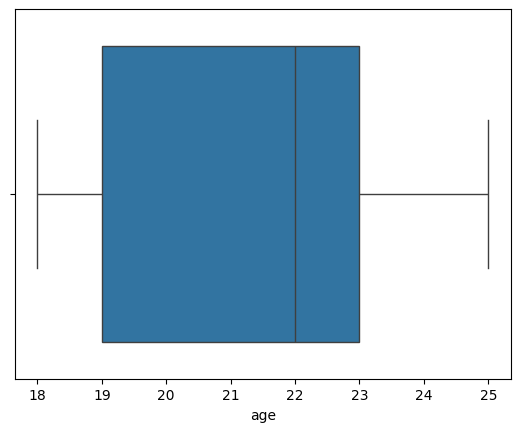

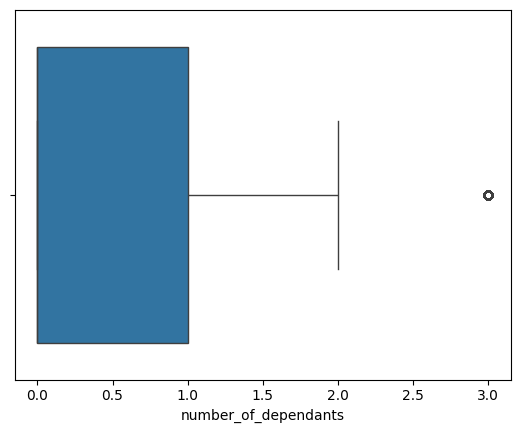

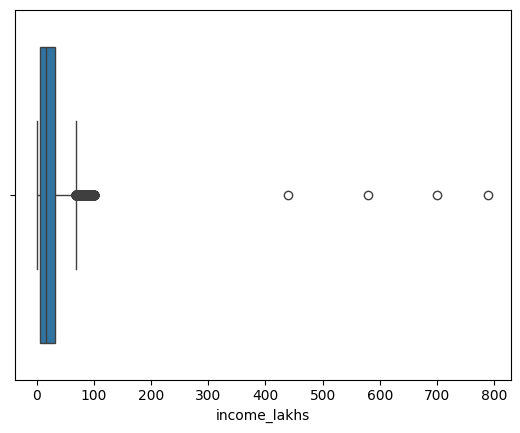

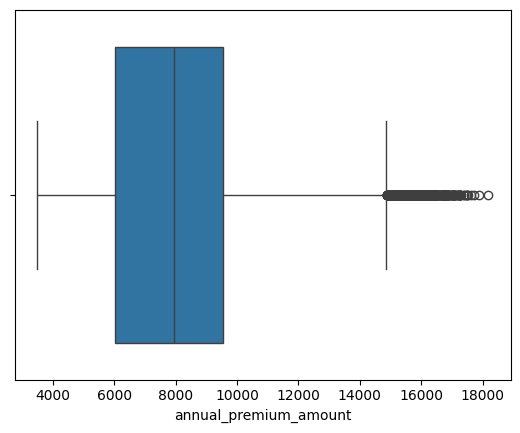

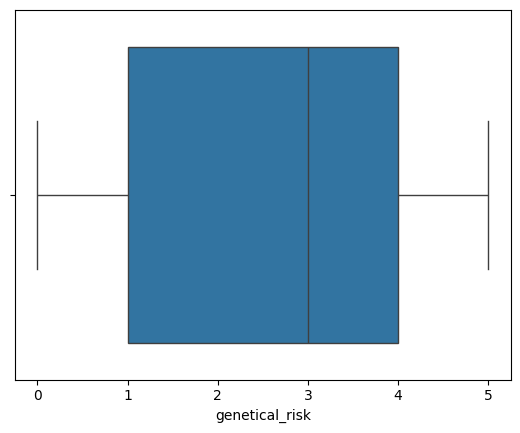

In [20]:
for col in numeric_columns:
    sns.boxplot(x=df[col])
    plt.show()

# TREATING 'age' COLUMN

In [21]:
df[df.age>100]['age'].unique()

array([], dtype=int64)

In [22]:
df1 = df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267,2.503932
std,2.294052,0.937200,23.420493,2749.906347,1.710203
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


# TREATING 'income_lakhs' COLUMN

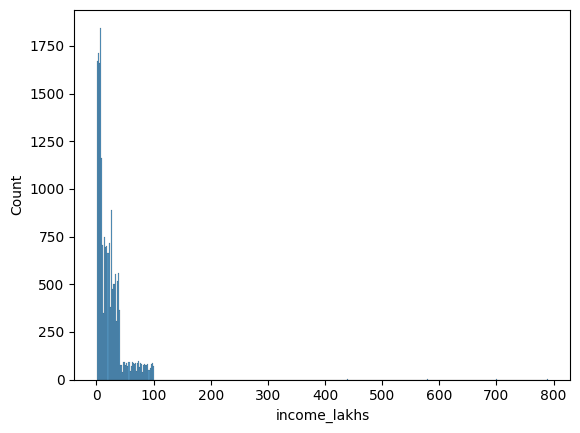

In [23]:
sns.histplot(df1.income_lakhs)
plt.show()

In [24]:
df1.income_lakhs.quantile([0.25, 0.75])

0.25     6.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [25]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

In [26]:
quantile_threshold_income = df1.income_lakhs.quantile(0.999)
quantile_threshold_income

np.float64(100.0)

In [27]:
df2 = df1[df1.income_lakhs<=quantile_threshold_income].copy()

In [28]:
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263,2.503883
std,2.294248,0.937238,21.732062,2749.912486,1.710184
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.000000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,100.000000,18186.000000,5.000000


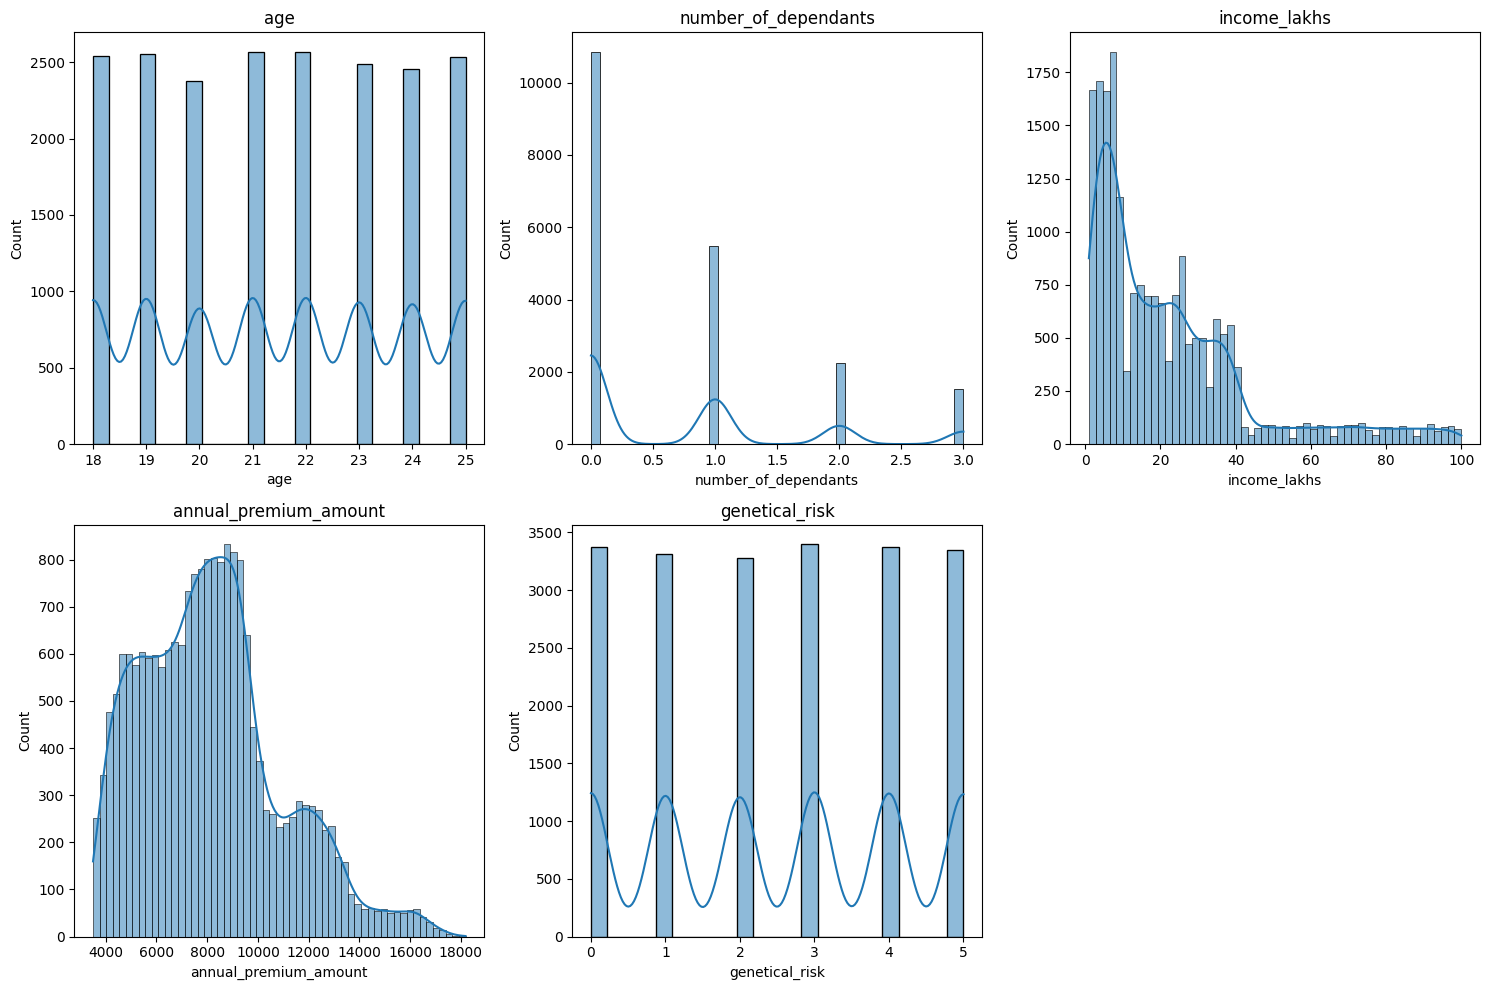

In [29]:
import math

n_plots = 5
n_cols = 3
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_columns[:n_plots]):
    sns.histplot(df2[col], kde=True, ax=axes[i])
    axes[i].set_title(col)

# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


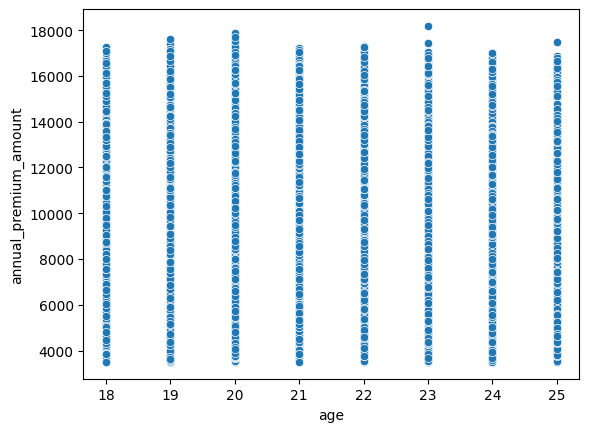

In [30]:
sns.scatterplot(df2, x = 'age', y = 'annual_premium_amount')
plt.show()

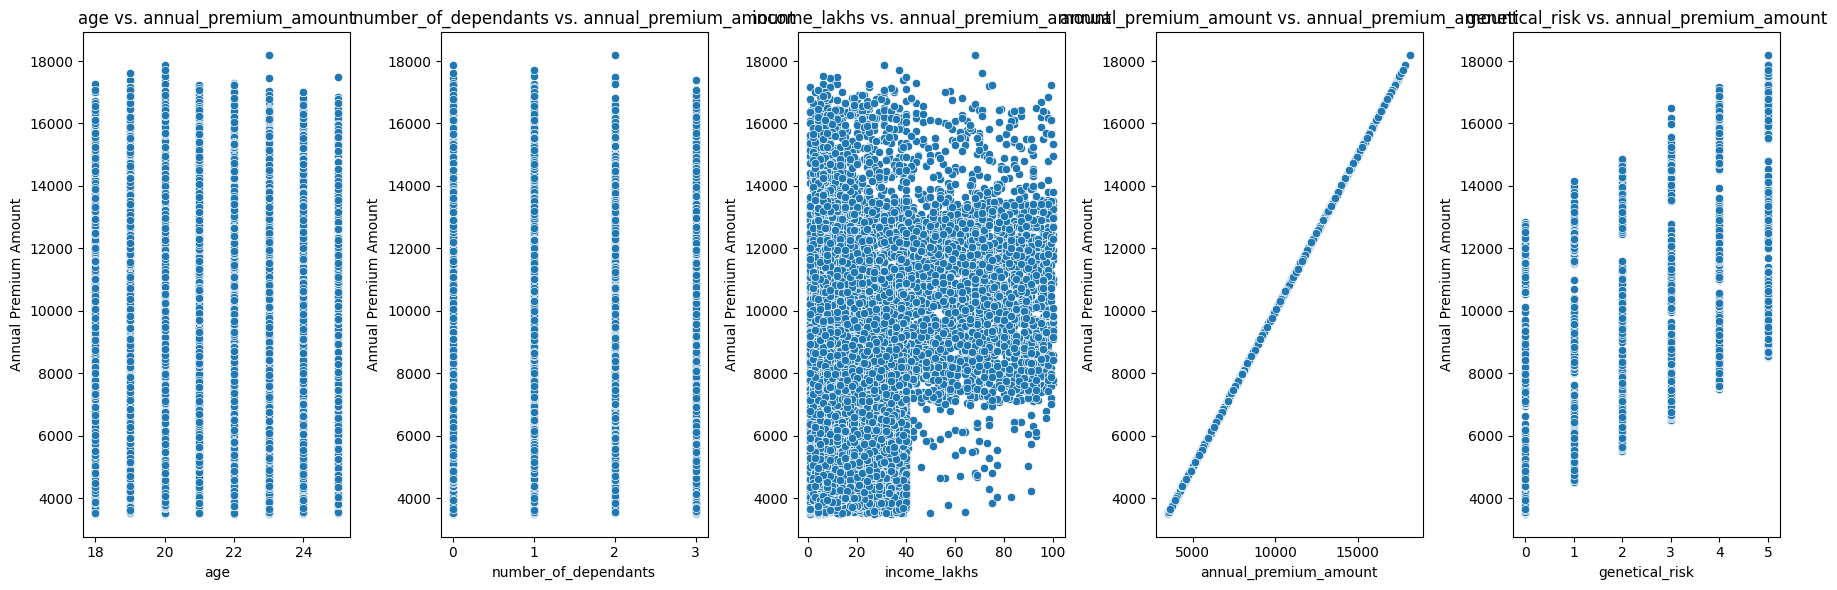

In [31]:
fig, axes = plt.subplots(1, (len(numeric_columns)), figsize = (18,6))

for ax, column in zip(axes, numeric_columns):
    sns.scatterplot(x = df2[column], y = df2['annual_premium_amount'], ax=ax)
    ax.set_title(f'{column} vs. annual_premium_amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()
plt.show()

In [32]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
categorical_columns

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [33]:
for col in categorical_columns:
    print(col, ':', df2[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [34]:
df2['smoking_status'].replace({ #here, there were too many redundant types under 'smoking_status' column, so we fixed it
    'Smoking=0' : 'No Smoking',
    'Does Not Smoke' : 'No Smoking',
    'Not Smoking' : 'No Smoking'
}, inplace = True)
df2['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

In [35]:
gender_count = df2['gender'].value_counts(normalize = True)
gender_count

gender
Male      0.550383
Female    0.449617
Name: proportion, dtype: float64

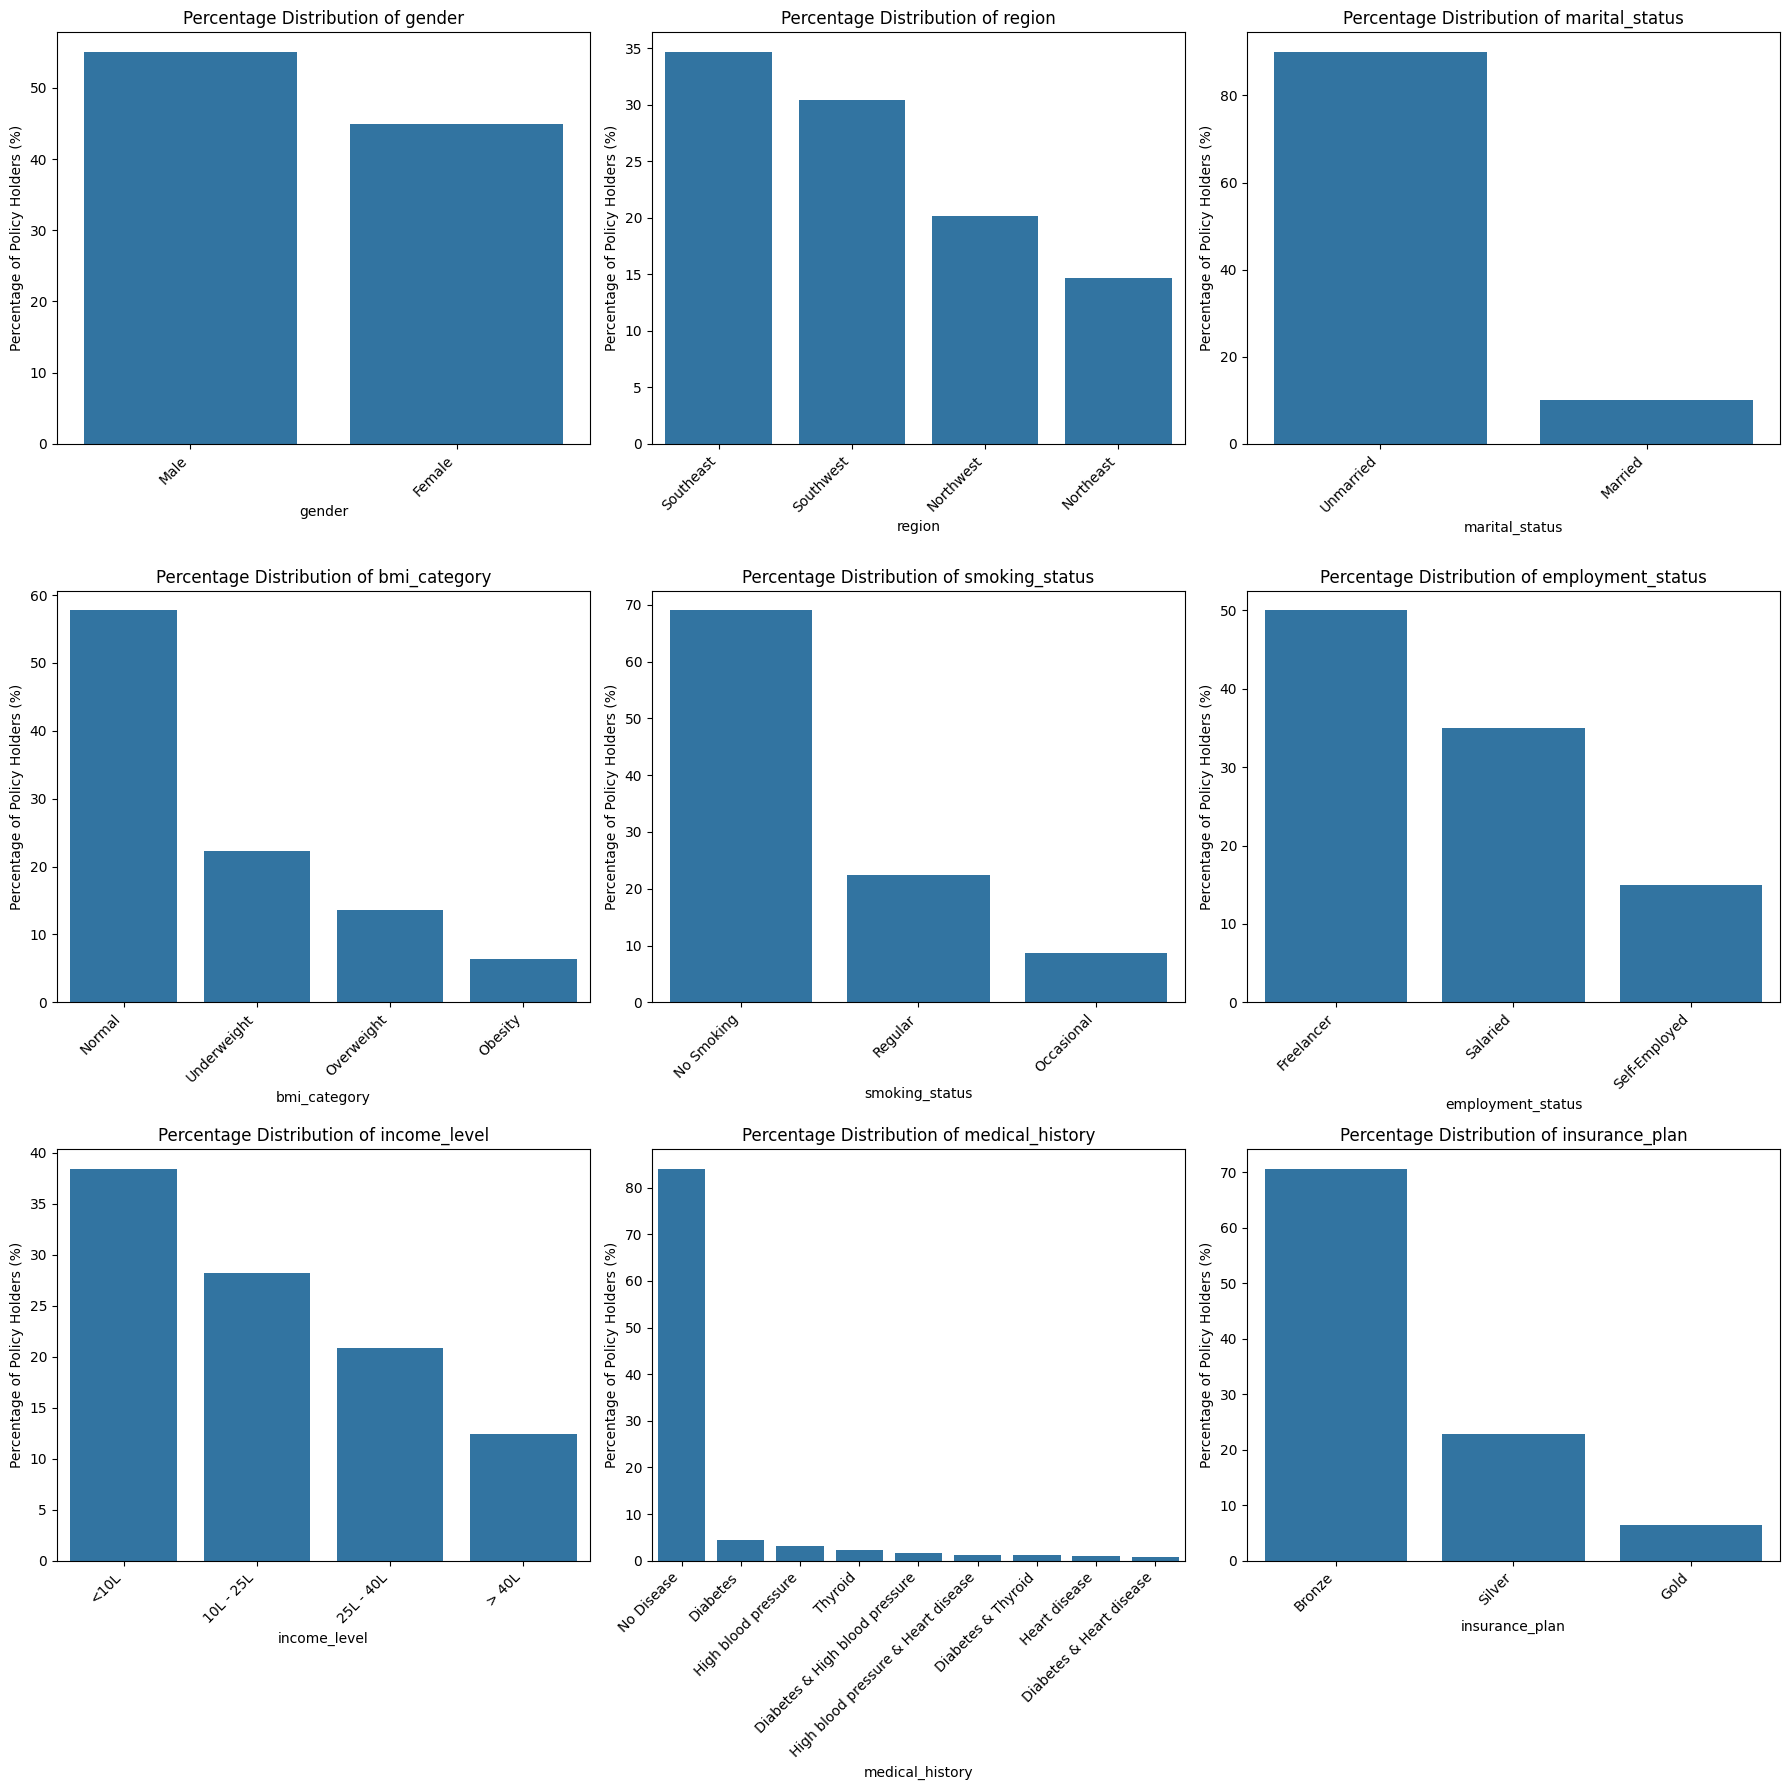

In [36]:
fig, axes = plt.subplots(3,3, figsize = (18,18))
axes = axes.flatten()

for ax, column in zip(axes, categorical_columns):
    category_count = df2[column].value_counts(normalize = True) * 100

    sns.barplot(x = category_count.index, y = category_count.values, ax = ax)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Percentage of Policy Holders (%)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
plt.tight_layout()
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         4508   326     828
25L - 40L         3382   209     608
<10L              6172   404    1145
> 40L              115   366    2023


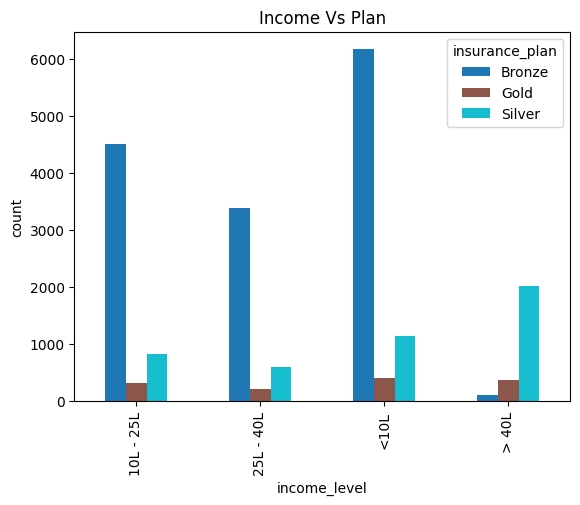

In [37]:
ct1 = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print(ct1)

ct1.plot(kind = 'bar', colormap='tab10')
plt.title('Income Vs Plan')
plt.ylabel('count')
plt.show()

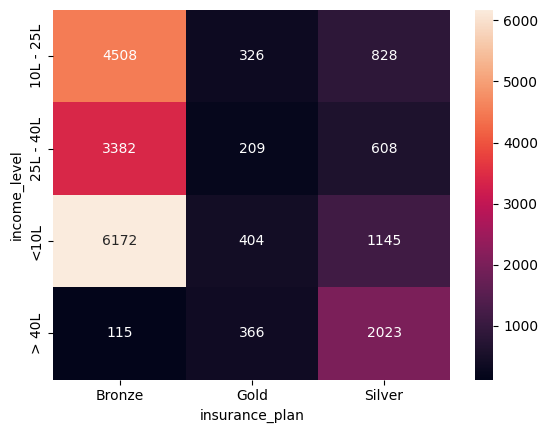

In [38]:
sns.heatmap(ct1, annot = True, fmt = 'd')
plt.show()

# FEATURE ENGINEERING

#### MEDICAL HISTORY AND DISEASE

In [39]:
df2.medical_history.unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [40]:
# we set some kind of severety value to each disease after *imaginary company discussion, for easier classification
risk_scores = {
    "diabetes" : 6,
    "heart disease" : 8,
    "high blood pressure" : 6,
    "thyroid" : 5,
    "no disease" : 0,
    "none" : 0
}

df2[['disease1', 'disease2']] = df2.medical_history.str.split(" & ", expand = True).apply(lambda  x: x.str.lower())
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4,high blood pressure,None
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3,no disease,None
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4,no disease,None


In [41]:
df2['disease1'].fillna('none', inplace = True)
df2['disease2'].fillna('none', inplace = True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score']-min_score) / (max_score - min_score)
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3,no disease,none,0,0.000000


#### INSURANCE PLAN & INCOME LEVEL

In [42]:
df2.insurance_plan.unique()

array(['Silver', 'Bronze', 'Gold'], dtype=object)

In [43]:
df2['insurance_plan'] = df2['insurance_plan'].map({
    'Bronze' : 1,
    'Silver' : 2,
    'Gold' : 3
})

In [44]:
df2.insurance_plan.unique()

array([2, 1, 3])

In [45]:
df2.income_level.unique()

array(['> 40L', '<10L', '10L - 25L', '25L - 40L'], dtype=object)

In [46]:
df2['income_level'] = df2['income_level'].map({
    '<10L' : 1,
    '10L - 25L' : 2,
    '> 40L' : 3,
    '25L - 40L' : 4
})

In [47]:
df2.income_level.unique()

array([3, 1, 2, 4])

In [48]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,3,99,High blood pressure,2,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,1,3,No Disease,2,11050,3,no disease,none,0,0.000000


## ONE-HOT-ENCODING

In [49]:
nominal_features = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']

df3 = pd.get_dummies(df2, columns = nominal_features, drop_first = True, dtype = int)
df3.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,3,99,High blood pressure,2,13365,4,high blood pressure,none,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,3,no disease,none,...,0,0,1,0,0,1,0,0,0,0
2,21,0,3,97,No Disease,2,11857,4,no disease,none,...,1,0,1,0,0,0,0,1,1,0


In [50]:
df4 = df3.drop(['medical_history', 'disease1', 'disease2', 'total_risk_score'], axis = 1)
df4.head(2)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,3,99,2,13365,4,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,3,0.000000,0,1,0,0,1,0,0,1,0,0,0,0


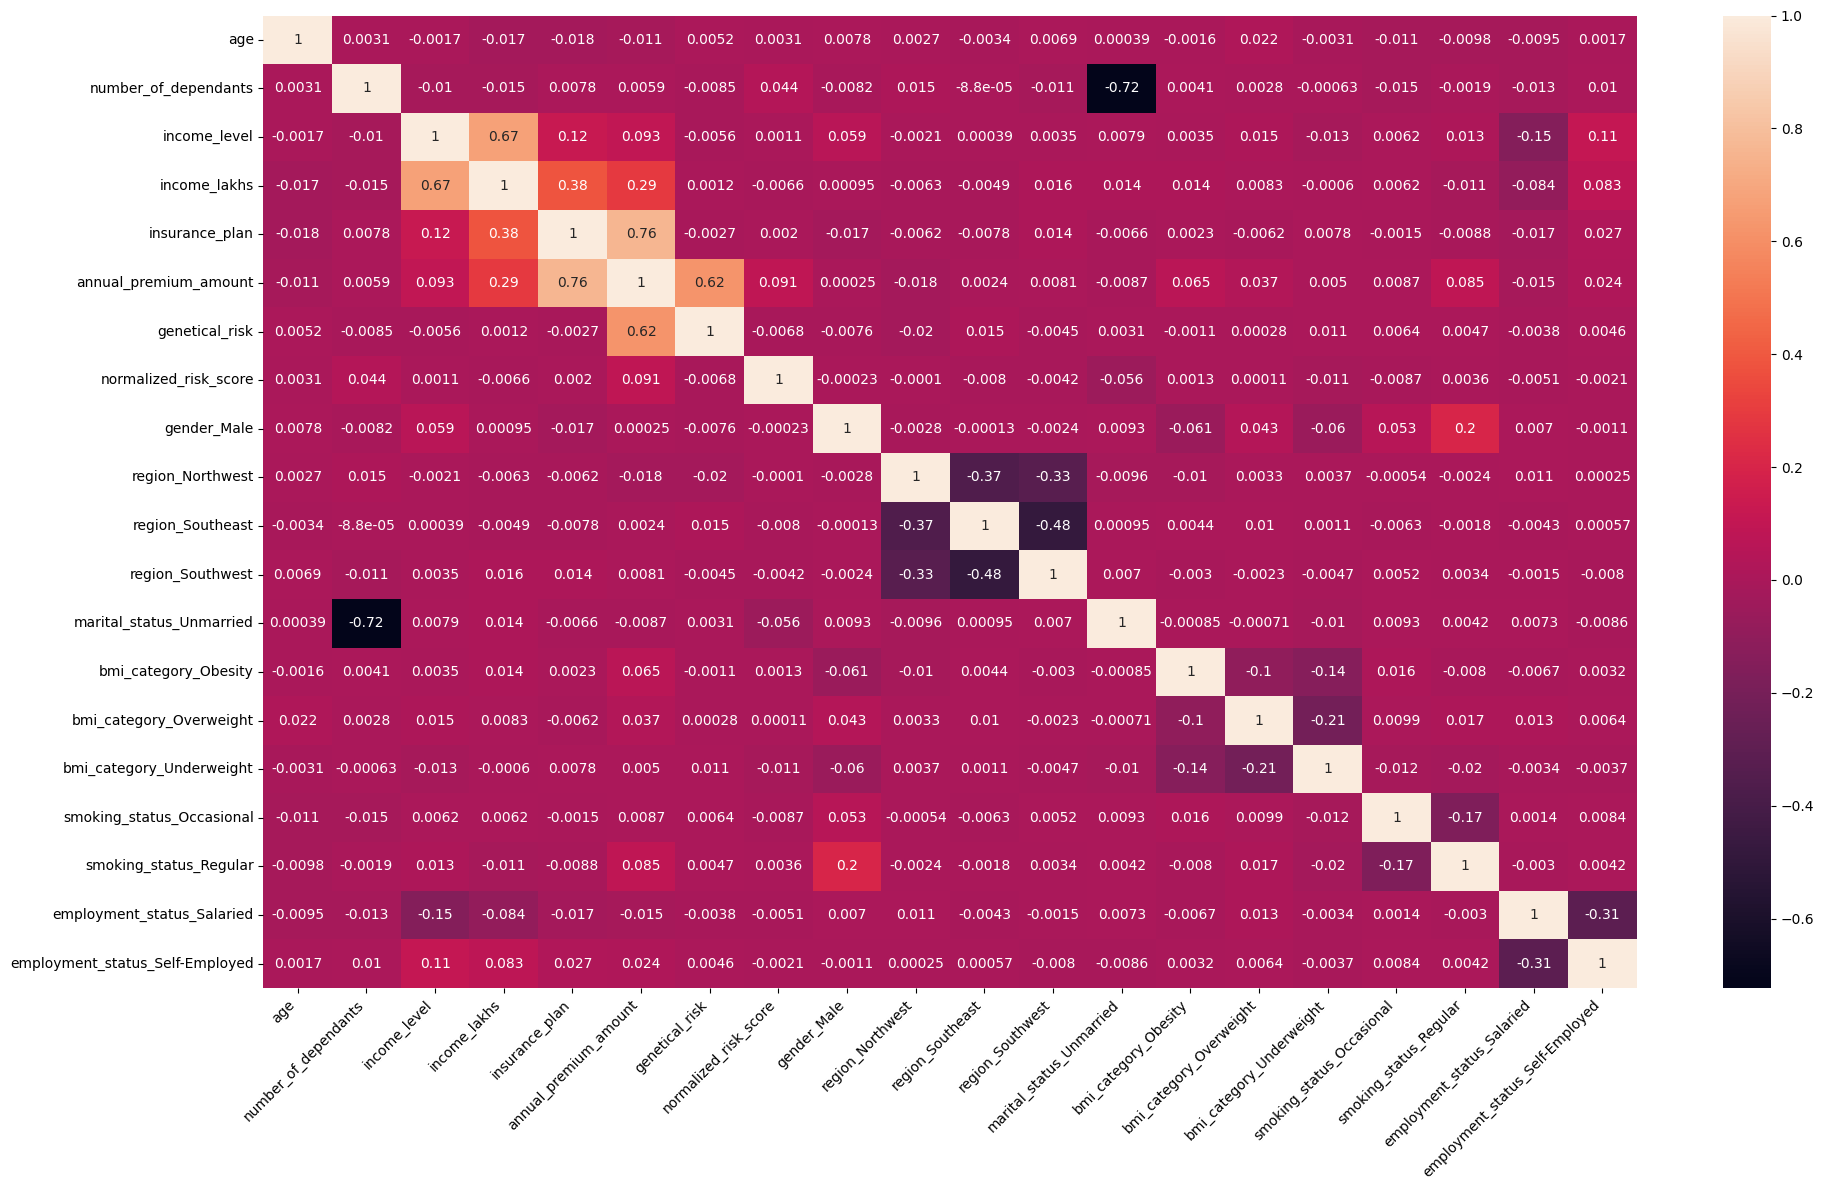

In [51]:
cm = df4.corr()

plt.figure(figsize = (20,12))
sns.heatmap(cm, annot = True)
plt.xticks(rotation = 45, ha = 'right')
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

In [82]:
X = df4.drop('annual_premium_amount', axis = "columns")
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler
to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan', 'genetical_risk']
scaler = MinMaxScaler()

X[to_scale] = scaler.fit_transform(X[to_scale])
X.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,0.666667,0.989899,0.5,0.8,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.000000,0.020202,0.5,0.6,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,0.666667,0.969697,0.5,0.8,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.333333,0.141414,0.0,0.4,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.333333,0.131313,0.0,0.2,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


In [83]:
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.386123,0.216064,0.179578,0.500777,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.383007,0.219516,0.300051,0.342037,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,0.600000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,0.800000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# all values in X is between 0-1 in every column that means our X is properly scaled

In [84]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [86]:
calculate_vif(X)

,column,VIF
0,age,3.155837
1,number_of_dependants,1.936584
2,income_level,3.916214
3,income_lakhs,4.344741
4,insurance_plan,1.647600
5,genetical_risk,2.981440
6,normalized_risk_score,1.154735
7,gender_Male,2.318870
8,region_Northwest,2.155017
9,region_Southeast,2.991916


In [87]:
calculate_vif(X.drop('income_level', axis = 'columns'))

,column,VIF
0,age,3.153255
1,number_of_dependants,1.927788
2,income_lakhs,2.294155
3,insurance_plan,1.587868
4,genetical_risk,2.981158
5,normalized_risk_score,1.154453
6,gender_Male,2.301658
7,region_Northwest,2.153423
8,region_Southeast,2.989301
9,region_Southwest,2.743932


In [88]:
X_reduced = X.drop('income_level', axis = 'columns')
X_reduced.head(2)

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.989899,0.5,0.8,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.0,0.020202,0.5,0.6,0.000000,0,1,0,0,1,0,0,1,0,0,0,0


# MODEL TRAINING & FINE TUNING

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size = 0.3, random_state = 10) 

print("X train", X_train.shape)
print('X test', X_test.shape)
print('y train', y_train.shape)
print('y test', y_test.shape)

X train (14060, 18)
X test (6026, 18)
y train (14060,)
y test (6026,)


In [90]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
test_score = lr_model.score(X_test, y_test)
train_score = lr_model.score(X_train, y_train)
train_score, test_score

(0.988297900194864, 0.9887263253056615)

In [91]:
y_pred_lr = lr_model.predict(X_test) 
mse = mean_squared_error(y_test, y_pred_lr)
rmse = np.sqrt(mse)
print('Linear Regressor ==> MSE: ', mse, 'RMSE: ', rmse)

Linear Regressor ==> MSE:  85732.34377930452 RMSE:  292.8008602776032


# X_test.head(1)

In [92]:
feature_weight = lr_model.coef_
feature_weight

array([-7.22903185e+00,  1.95361819e+01, -1.26452776e+00,  7.00112526e+03,
        4.99698873e+03,  1.10914836e+03,  8.17798831e+00,  1.67735268e+00,
       -3.27532710e+00,  6.31709531e+00,  1.60689716e+01,  8.12844929e+02,
        4.00375598e+02,  1.07529819e+02,  2.05069661e+02,  6.10983280e+02,
        3.87836470e-02, -5.24201812e+00])

In [93]:
lr_model.intercept_

np.float64(3978.8235284382563)

In [94]:
X_test.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'genetical_risk', 'normalized_risk_score', 'gender_Male',
       'region_Northwest', 'region_Southeast', 'region_Southwest',
       'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

In [95]:
coef_df = pd.DataFrame(feature_weight, index = X_test.columns, columns = ['coefficients'])
coef_df = coef_df.sort_values(by = 'coefficients', ascending = True)
coef_df

,coefficients
age,-7.229032
employment_status_Self-Employed,-5.242018
region_Southeast,-3.275327
income_lakhs,-1.264528
employment_status_Salaried,0.038784
region_Northwest,1.677353
region_Southwest,6.317095
gender_Male,8.177988
marital_status_Unmarried,16.068972
number_of_dependants,19.536182


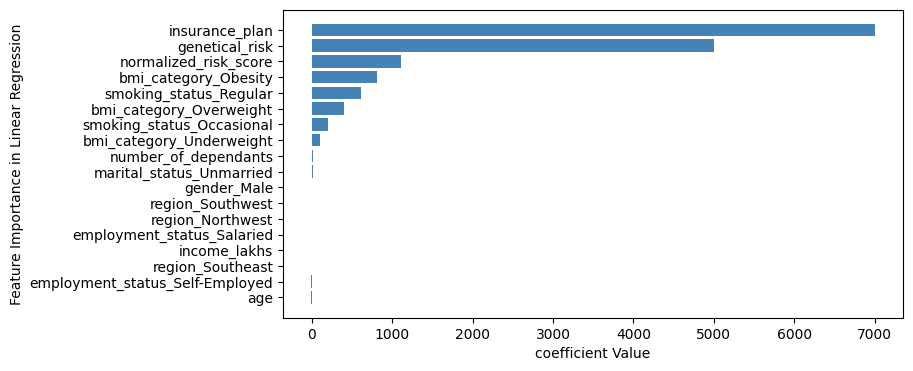

In [96]:
plt.figure(figsize = (8, 4))
plt.barh(coef_df.index, coef_df['coefficients'], color = 'steelblue')
plt.xlabel('coefficient Value')
plt.ylabel('Feature Importance in Linear Regression')
plt.show()

In [97]:
rg_model = Ridge(alpha = 10)
rg_model.fit(X_train, y_train)
test_score_rg = rg_model.score(X_test, y_test)
train_score_rg = rg_model.score(X_train, y_train)
train_score_rg, test_score_rg 
#this doest have much of a difference, so next we'll try XGboost

(0.9882386209794508, 0.9886848419551753)

In [98]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
test_score_xgb = xgb_model.score(X_test, y_test)
train_score_xgb = xgb_model.score(X_train, y_train)
train_score_xgb, test_score_xgb

(0.9925054907798767, 0.987729549407959)

In [99]:
y_pred_xgb = xgb_model.predict(X_test) 
mse_lr = mean_squared_error(y_test, y_pred_xgb)
rmse_lr = np.sqrt(mse_lr)
print('XGBoost Regressor ==> MSE: ', mse_lr, 'RMSE: ', rmse_lr)

XGBoost Regressor ==> MSE:  93312.703125 RMSE:  305.47128036036383


In [100]:
param_grid = {
    'n_estimators' : [20, 40, 50],
    'learning_rate' : [0.01, 0.1, 0.2],
    'max_depth' : [3, 4, 5]
}
random_search = RandomizedSearchCV(xgb_model, param_grid, n_iter = 10, cv = 3, scoring = 'r2')
random_search.fit(X_train, y_train)
random_search.best_score_

np.float64(0.9884945352872213)

In [101]:
random_search.best_params_

{'n_estimators': 40, 'max_depth': 4, 'learning_rate': 0.2}

In [102]:
best_model = random_search.best_estimator_

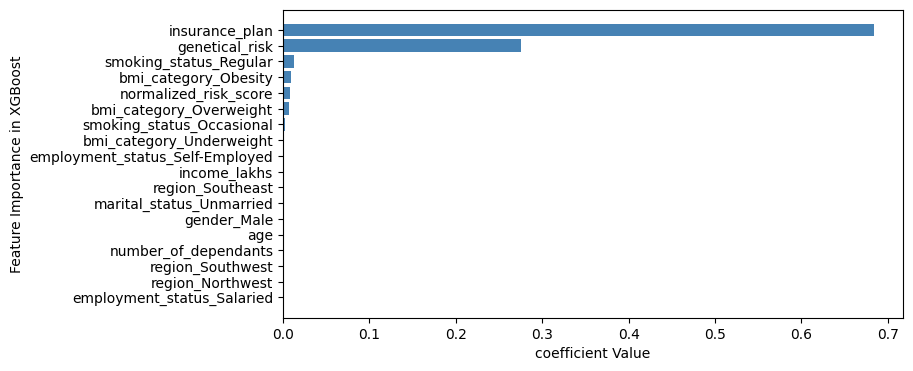

In [103]:
feature_importances = best_model.feature_importances_

coef_df2 = pd.DataFrame(feature_importances, index = X_test.columns, columns = ['coefficients'])
coef_df2 = coef_df2.sort_values(by = 'coefficients', ascending = True)

plt.figure(figsize = (8, 4))
plt.barh(coef_df2.index, coef_df2['coefficients'], color = 'steelblue')
plt.xlabel('coefficient Value')
plt.ylabel('Feature Importance in XGBoost')
plt.show()

### ERROR ANALYSIS

In [104]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_percentage = residuals*100/y_test

results_df = pd.DataFrame({
    'actual' : y_test,
    'predicted' : y_pred,
    'diff' : residuals,
    'diff_in_percent' : residuals_percentage
})
results_df.head()

,actual,predicted,diff,diff_in_percent
12774,6238,6104.094727,-133.905273,-2.146606
14758,9462,9616.156250,154.156250,1.629214
13205,5152,5585.136719,433.136719,8.407157
14278,6988,7419.788086,431.788086,6.178994
19351,4917,5107.060059,190.060059,3.865366


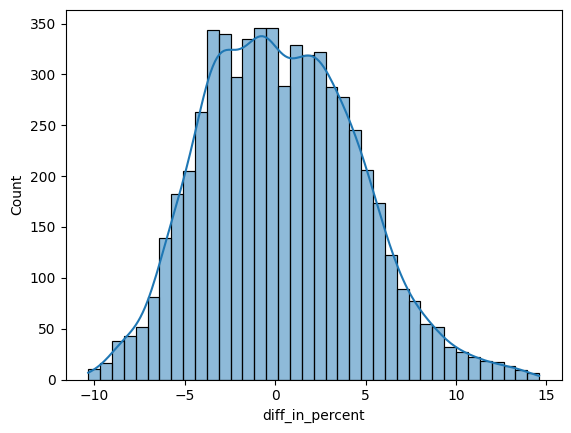

In [105]:
sns.histplot(results_df['diff_in_percent'], kde = True)
plt.show()

In [106]:
extreme_error_threshold = 10

extreme_results_df = results_df[np.abs(results_df.diff_in_percent) > extreme_error_threshold]
extreme_results_df.shape

(119, 4)

In [107]:
results_df.shape

(6026, 4)

In [108]:
extreme_error_in_percent = extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_error_in_percent

1.9747759707932293

In [109]:
extreme_results_df.index

Index([12669,  2918, 17084, 13565,  7181, 12285, 13476, 15481,  2948,  4919,
       ...
         355, 13574, 15166,  4204,  8692,  1986, 16062,  8008,  9714,  1534],
      dtype='int64', length=119)

In [110]:
extreme_error_df = X_test.loc[extreme_results_df.index]
extreme_error_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
12669,0.857143,0.0,0.000000,0.0,0.0,0.0,1,0,1,0,1,0,1,0,0,0,1,0
2918,0.285714,0.0,0.151515,0.0,0.2,0.0,1,1,0,0,1,0,0,0,0,0,1,0
17084,1.000000,0.0,0.353535,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0
13565,0.428571,0.0,0.242424,0.0,0.0,0.0,1,0,0,0,1,0,0,0,1,0,1,0
7181,0.571429,0.0,0.161616,0.0,0.0,0.0,1,0,0,1,1,0,0,0,0,0,0,0


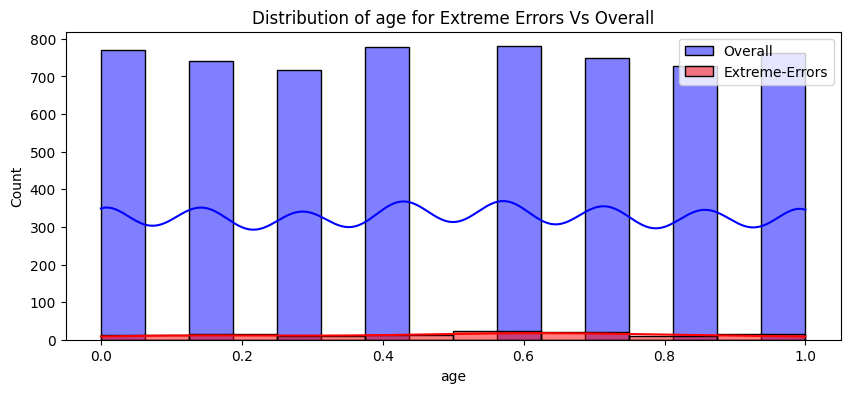

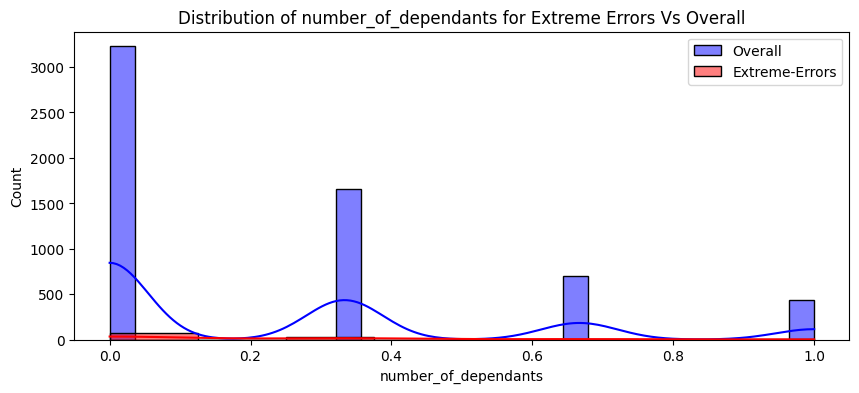

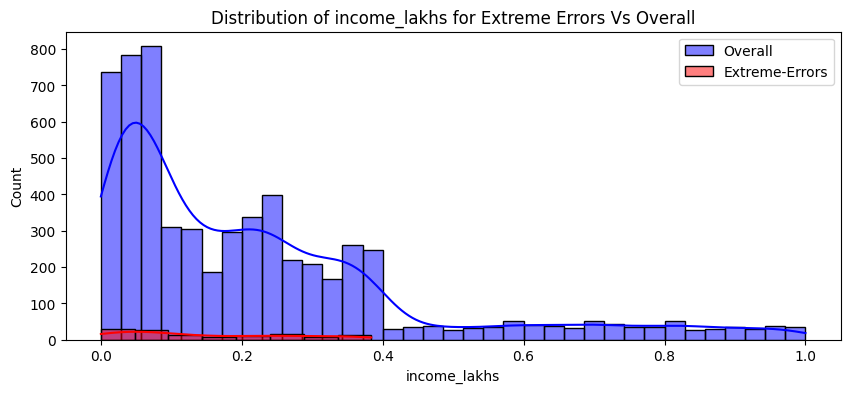

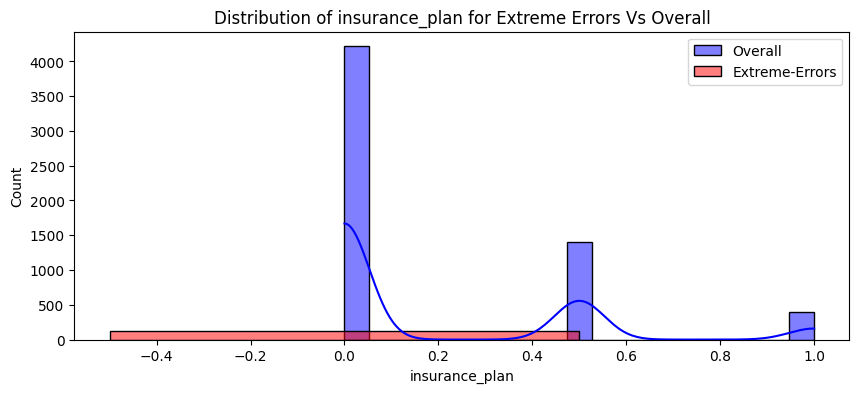

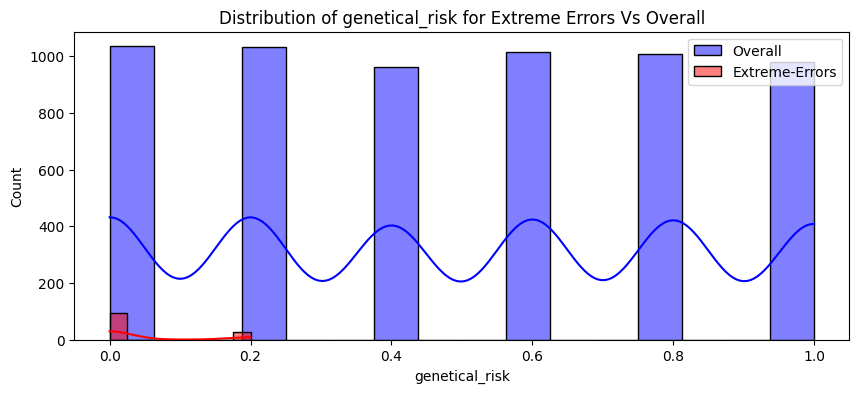

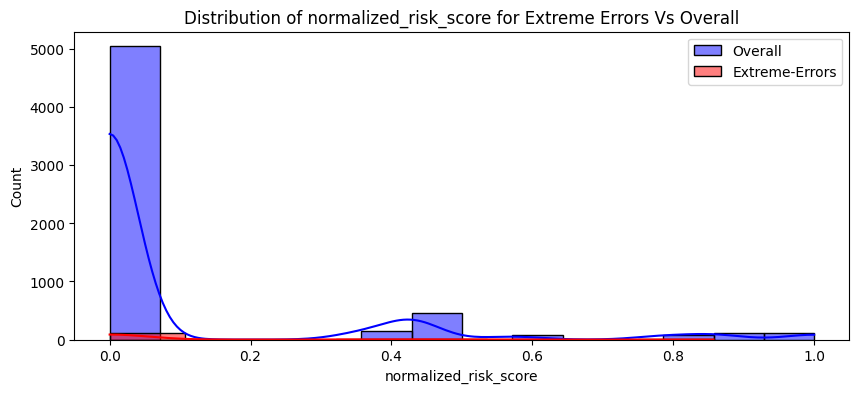

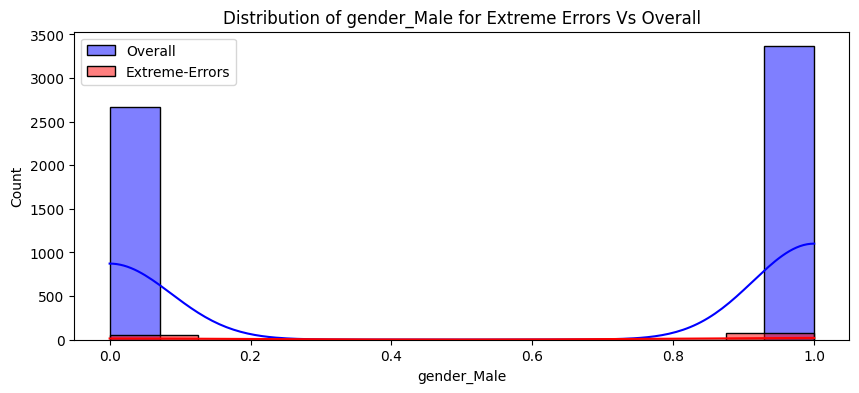

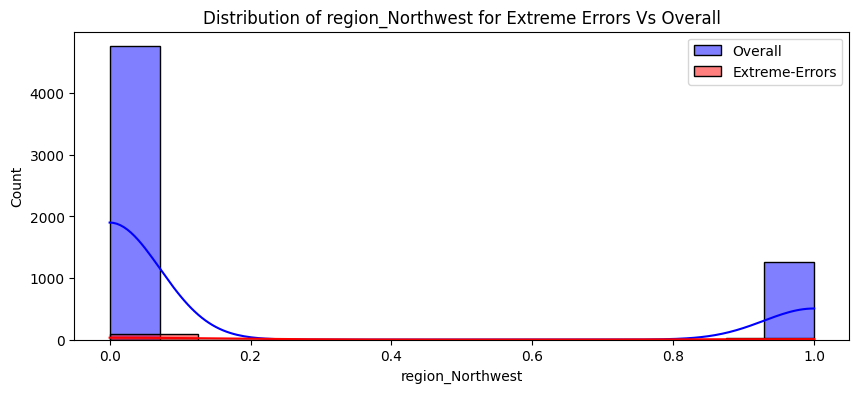

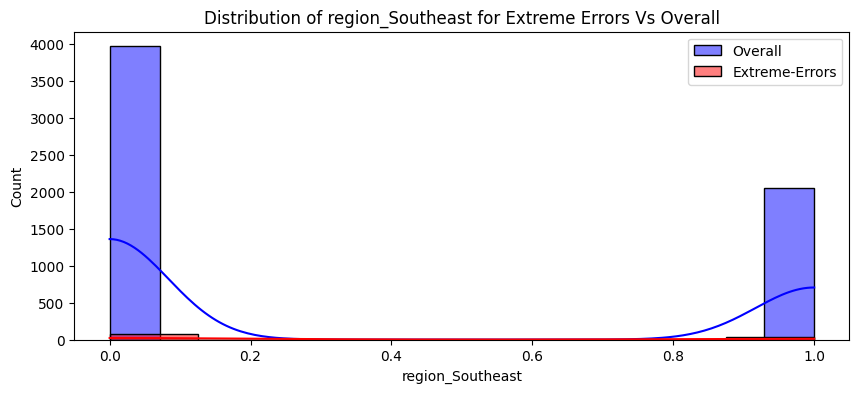

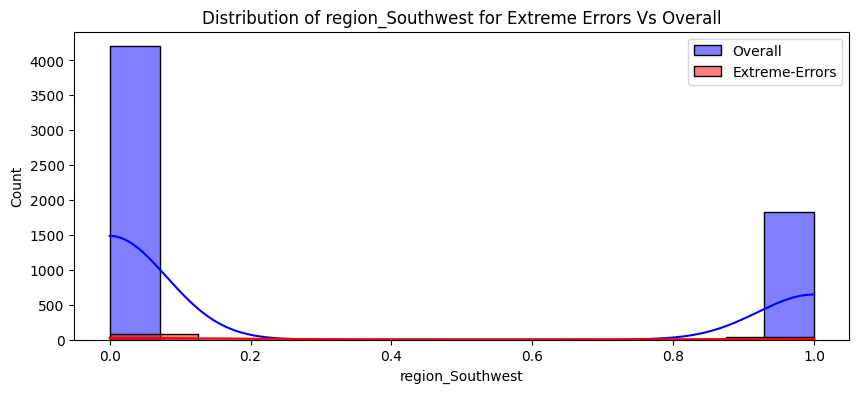

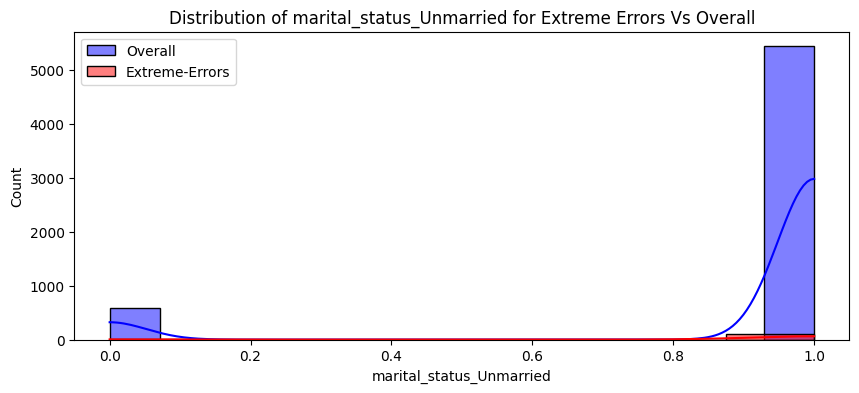

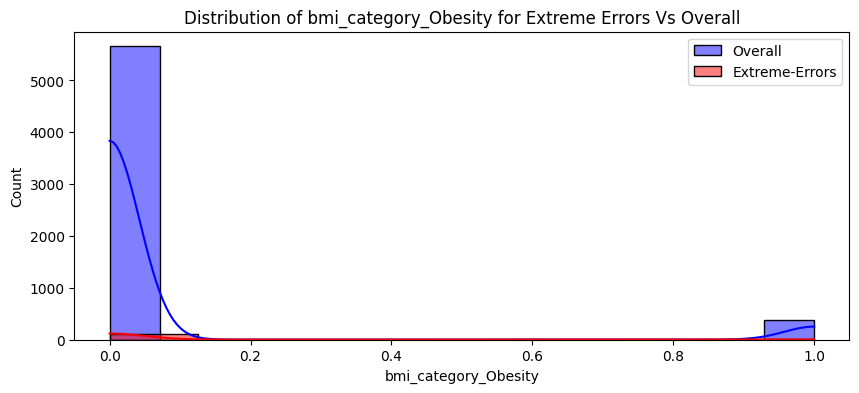

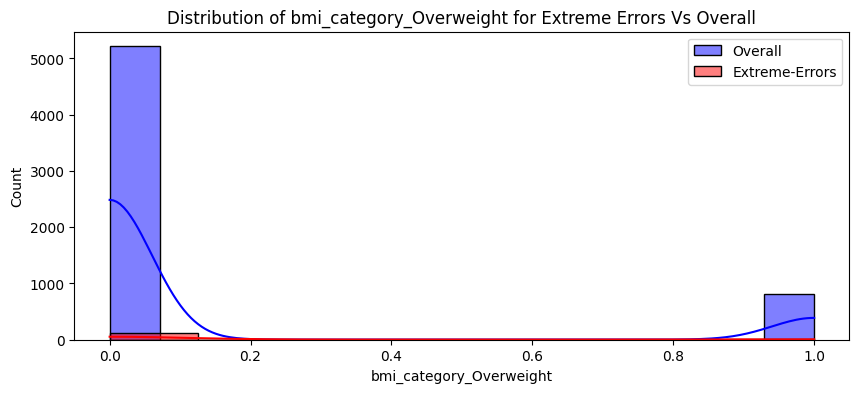

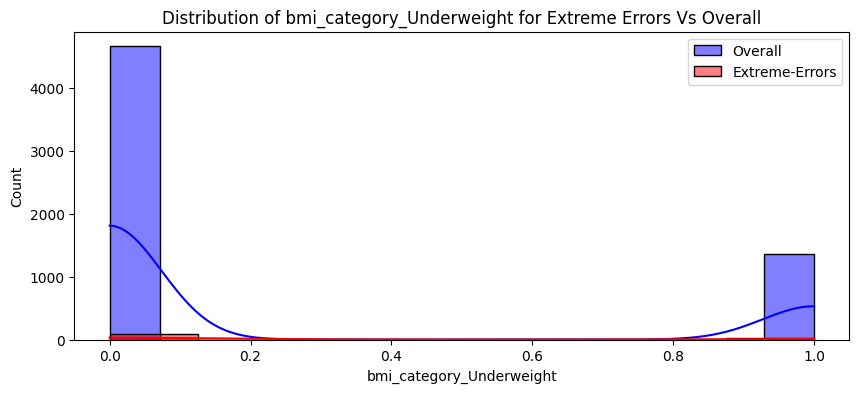

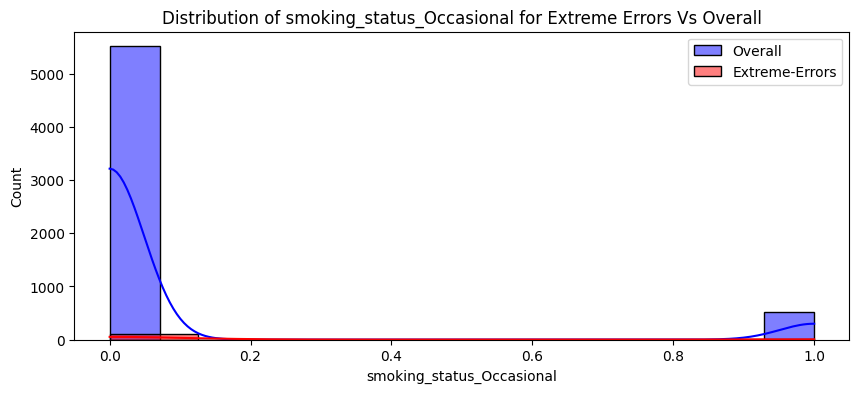

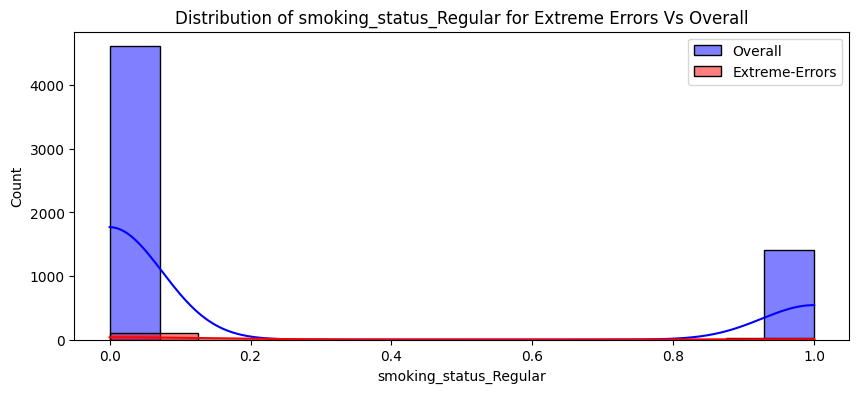

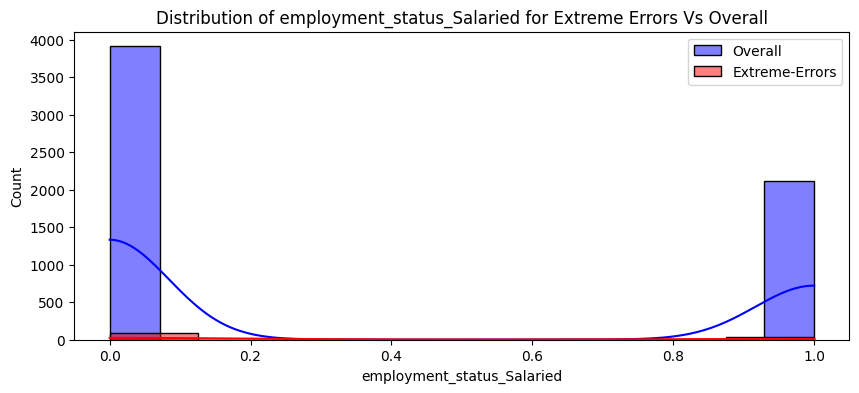

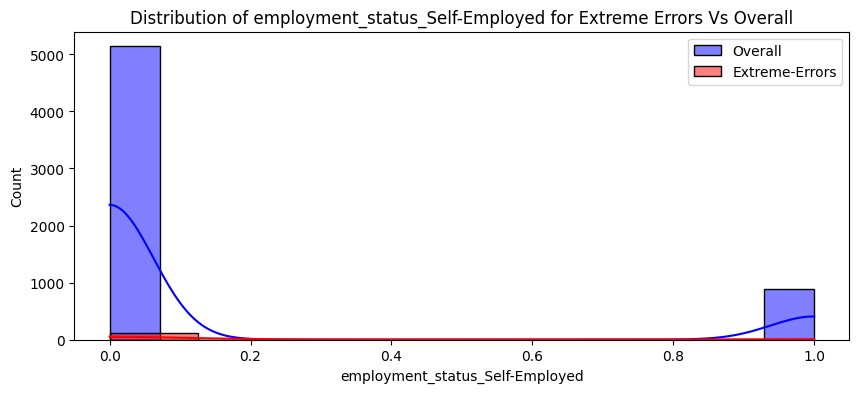

In [111]:
for features in X_test.columns:
    plt.figure(figsize = (10,4))
    sns.histplot(X_test[features], color = 'blue', label = 'Overall', alpha = 0.5, kde = True)
    sns.histplot(extreme_error_df[features], color = 'red', label = 'Extreme-Errors', kde = True)
    plt.legend()
    plt.title(f'Distribution of {features} for Extreme Errors Vs Overall')
    plt.show()

<Axes: xlabel='age', ylabel='Count'>

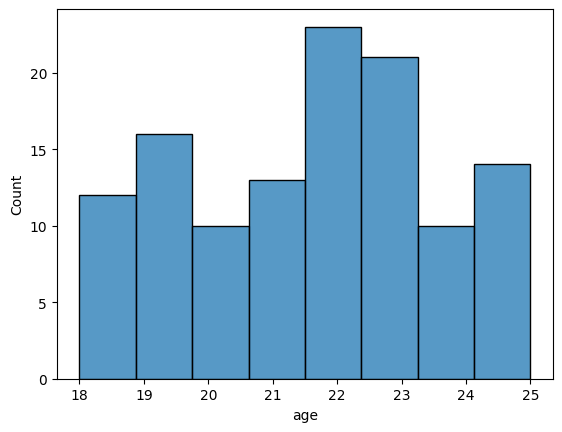

In [112]:
extreme_error_df['income_level'] = -1
df_fixed = pd.DataFrame()
df_fixed[to_scale] = scaler.inverse_transform(extreme_error_df[to_scale])
sns.histplot(df_fixed['age'])